# **Proyecto tasación inmuebles para la zona de Manises y alrededores, Valencia.**
---
---

- ### ***¿Qué problema o necesidad vamos a resolver?***

### La necesidad que este proyecto puede cubrir a la inmobiliaria de la zona de Manises **es la tasación inmediata del inmueble a particulares de la zona en la misma visita de la vivienda**.
---

- ### ***¿Qué solución aporta tu modelo de ML?***

### La ***posibilidad de automatizar procesos de burocracia después de la tasación*** es muy alta, y esto puede cubrir aún más la necesidad de la empresa y **optimizar todo el proceso que conlleva** desde la visita al inmueble hasta el pacto de su venta a cargo de la empresa.
---

+ ## *Primeros pasos para obtener datos y poder construir un dataset:*

### Debido a que la empresa no pudo facilitarme información y datos del histórico de viviendas vendidas, opté por utilizar la herramienta **WebScrapping** para *"pedir prestada"* la información de las viviendas a la venta de los siguientes portales:

- #### IDEALISTA.COM    
- #### PISOS.COM
- #### FOTOCASA.COM

**La zona a buscar es en Manises y sus alrededores para cada uno de los portales**

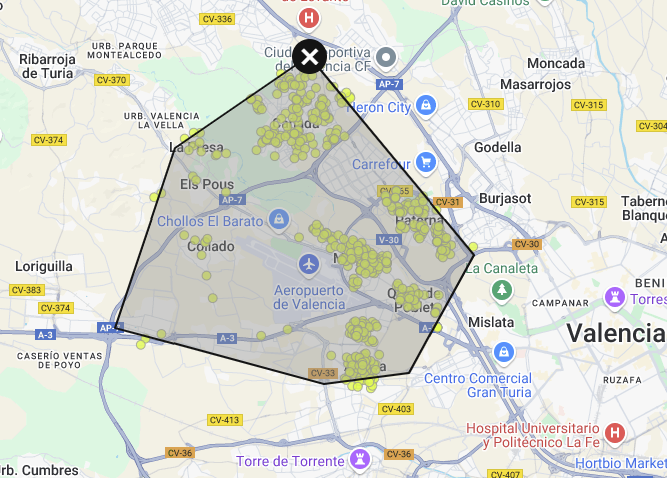

### Empezando por ***webscrapping_html.ipynb***, al **inspeccionar cada página** de los resultados de cada portal, se **guarda el HTML** en un fichero.txt donde luego se **extrae la informacion** con la librería ***Selenium***, resultando en un dataframe para cada portal, ya trabajado para extraer sólo los datos relevantes. 

In [ ]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import os
import re

# Ruta de la carpeta IDEALISTA que contiene el HTML
carpeta = "../data/raw/idealista"

# Lista para almacenar todos los datos de viviendas
datos_todas_viviendas = []

# Iterar sobre todos los archivos .txt de la carpeta
for archivo in os.listdir(carpeta):
    if archivo.endswith(".txt"):
        # Leer el contenido del archivo
        print(archivo)
        ruta_archivo = os.path.join(carpeta, archivo)
        with open(ruta_archivo, 'r', encoding='utf-8') as file:
            html_content = file.read()
        
        # Crear el objeto BeautifulSoup
        soup = bs(html_content, "lxml")
        
        # Buscar el main content
        main_content = soup.select('main.listing-items.core-vitals-listing-map#main-content')
        if not main_content:
            print(f"No se encontró 'main-content' en el archivo: {archivo}")
            continue
        
        # Buscar todos los <div class="item-info-container"> dentro de main_content
        item_info_containers = main_content[0].select('div.item-info-container')
        
        for container in item_info_containers:
            # Agencia
            # agencia = container.select_one('picture.logo-branding a').get('title', '').strip() if container.select_one('picture.logo-branding a') else None
            
            # Título, calle y barrio
            enlace_vivienda = container.select_one('a.item-link')
            titulo = enlace_vivienda.get_text(strip=True) if enlace_vivienda else None
            title_attr = enlace_vivienda.get('title', '') if enlace_vivienda else ''

            # Extraer calle y barrio del título
            if ',' in title_attr:  # Si hay comas en el título
                partes = [parte.strip() for parte in title_attr.split(',')]  # Dividir por comas y eliminar espacios
                calle = partes[0] if len(partes) > 0 else None  # La primera parte es la calle
                municipio = partes[-1] if len(partes) > 0 else None # El último elemento es el municipio
                barrio = partes[-2] if len(partes) > 1 else None  # El penúltimo elemento es el barrio
            else:  # Si no hay comas
                palabras = title_attr.split()  # Dividir el título por espacios
                if len(palabras) > 2:  # Si hay más de dos palabras
                    calle = ' '.join(palabras[:-2])  # Todo excepto las dos últimas palabras como calle
                    barrio = ' '.join(palabras[-2:])  # Las dos últimas palabras como barrio
                    municipio = "Manises"
                else:  # Si hay dos palabras o menos
                    calle = None  # No hay suficiente información para la calle
                    barrio = ' '.join(palabras)  # Tomar todo como barrio
                    municipio = "Manises"
                    
            # Precio
            precio = container.select_one('div.price-row span.item-price').get_text(strip=True) if container.select_one('div.price-row span.item-price') else None
            precio = re.sub(r'[^\d]', '', precio) if precio else None  # Eliminar caracteres no numéricos
            
            # Habitaciones, metros cuadrados y planta
            detalles = container.select('div.item-detail-char span.item-detail')
            habitaciones = re.sub(r'[^\d]', '', detalles[0].get_text(strip=True)) if len(detalles) > 0 else None
            metros_cuadrados = re.sub(r'[^\d]', '', detalles[1].get_text(strip=True)) if len(detalles) > 1 else None
            planta = None
            for detalle in detalles:
                texto = detalle.get_text(strip=True)
                if "hab" in texto:
                    habitaciones = re.sub(r'[^\d]', '', texto)
                elif "m²" in texto:
                    metros_cuadrados = re.sub(r'[^\d]', '', texto)
                elif "Planta" in texto:
                    planta = texto

            # Tipo Vivienda
            if 'piso' in title_attr.lower():
                tipo_vivienda = 'Piso'
            elif 'casa' in title_attr.lower() and metros_cuadrados and float(metros_cuadrados) <= 100:
                tipo_vivienda = 'Casa'
            elif ('casa' in title_attr.lower() or 'chalet' in title_attr.lower()) and metros_cuadrados and float(metros_cuadrados) > 100:
                tipo_vivienda = 'Chalet'
            else:
                tipo_vivienda = None

            # Descripción
            descripcion_elemento = container.select_one('div.item-description p.ellipsis')
            descripcion = descripcion_elemento.get_text(strip=True) if descripcion_elemento else None
            
            # Número de baños (buscar "baños" en la descripción)
            numero_baños = None
            if descripcion:
                match = re.search(r'(\d+)\s*baños?', descripcion)
                numero_baños = match.group(1) if match else None

            elif descripcion and numero_baños is None:
                # Busca expresiones como "1 baño", "2 baños", "baño individual", etc.
                match = re.search(r'(\d+)\s*(?:baño|baños?|aseos?|wc)', descripcion, re.IGNORECASE)
                numero_baños = match.group(1) if match else None
            
            # Etiquetas
            etiquetas = [tag.get_text(strip=True) for tag in container.select('div.listing-tags-container span.listing-tags')]
            
            # Garaje incluido
            garaje = "Sí" if container.select_one('div.price-row span.item-parking') else "No"

            # Almacenar los datos en un diccionario
            datos_vivienda = {
                'calle': calle,
                'barrio': barrio,
                'municipio': municipio,
                'tipo_vivienda': tipo_vivienda,
                'titulo': titulo,
                'habitaciones': habitaciones,
                'metros_cuadrados': metros_cuadrados,
                'aseos': numero_baños,
                'planta': planta,
                'descripcion': descripcion,
                'etiquetas': etiquetas,
                'garaje': garaje,
                'precio': precio
            }
            datos_todas_viviendas.append(datos_vivienda)

# Crear un DataFrame consolidado
ideal = pd.DataFrame(datos_todas_viviendas)

# Convertir las columnas a tipo numérico
ideal['precio'] = ideal['precio'].astype(str).str.replace(r'[^\d]', '', regex=True)  # Eliminar caracteres no numéricos
ideal['precio'] = pd.to_numeric(ideal['precio'], errors='coerce') 
ideal['habitaciones'] = pd.to_numeric(ideal['habitaciones'], errors='coerce')
ideal['metros_cuadrados'] = pd.to_numeric(ideal['metros_cuadrados'], errors='coerce')
ideal['aseos'] = pd.to_numeric(ideal['aseos'], errors='coerce')

print(ideal.shape)
ideal.head(2)

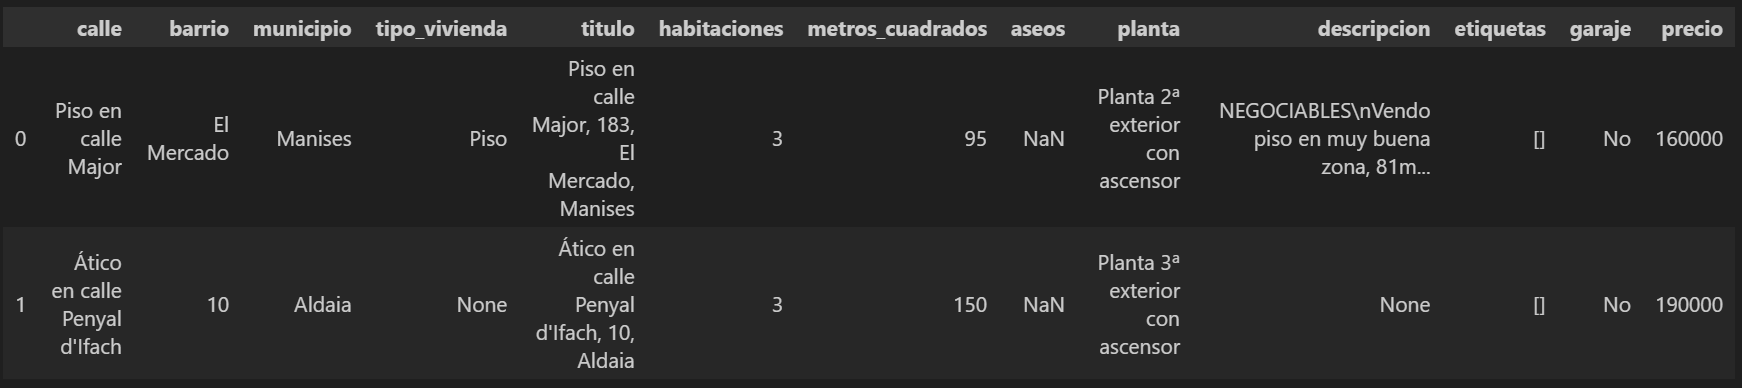

### Asi para cada portal, **exportando cada dataframe en un CSV** para posteriormente en el notebook ***featuring_enginnering.ipynb*** se terminan concatenando todos para tener un **dataframe general y ya poder trabajar los datos.**

In [ ]:
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 1211 entries, 0 to 1210
# Data columns (total 13 columns):
#  #   Column            Non-Null Count  Dtype  
# ---  ------            --------------  -----  
#  0   calle             1211 non-null   object 
#  1   barrio            1211 non-null   object 
#  2   municipio         1127 non-null   object 
#  3   tipo_vivienda     1147 non-null   object 
#  4   titulo            1211 non-null   object 
#  5   habitaciones      1119 non-null   float64
#  6   metros_cuadrados  1210 non-null   float64
#  7   aseos             631 non-null    float64
#  8   planta            459 non-null    object 
#  9   descripcion       1193 non-null   object 
#  10  etiquetas         1211 non-null   object 
#  11  garaje            1211 non-null   object 
#  12  precio            1206 non-null   float64
# dtypes: float64(4), object(9)
# memory usage: 123.1+ KB

- ### ***¿Qué modelos has probado?***




- ¿Qué resultados y conclusiones has obtenido? 
- ¿Cuáles han sido las variables de mayor impacto? 
- ¿Qué decisiones o acciones te permiten llevar a cabo tu modelo? ¿Qué consecuencias tiene en negocio? Muy importante